**STOCK PRICE PREDICTOR**

In [1]:
!pip install yfinance pandas numpy scikit-learn matplotlib seaborn plotly


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go


In [3]:
stock = "AAPL"  # Example: Apple
df = yf.download(stock, start="2015-01-01", end="2024-12-31")
df.head()


/tmp/ipython-input-3344442573.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237555,24.705324,23.798604,24.694239,212818400
2015-01-05,23.554743,24.086803,23.368523,24.006994,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805077,24.862717,24.097880,24.215378,237458000


In [4]:
df["MA10"] = df["Close"].rolling(10).mean()
df["MA50"] = df["Close"].rolling(50).mean()
df["Return"] = df["Close"].pct_change()

df = df.dropna()
df.head()


Price,Close,High,Low,Open,Volume,MA10,MA50,Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2015-03-16,27.809694,27.809694,27.346757,27.571548,143497200,27.994206,26.586998,0.011004
2015-03-17,28.274864,28.337183,27.965497,28.021138,204092400,27.942570,26.667744,0.016727
2015-03-18,28.593130,28.746702,28.125741,28.265957,261083600,27.941012,26.768512,0.011256
2015-03-19,28.377239,28.766731,28.354983,28.655447,183238000,27.965272,26.864918,-0.007550
2015-03-20,28.021133,28.577548,27.856435,28.544165,274780400,27.949692,26.947595,-0.012549


In [5]:
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])
fig.update_layout(title=f"{stock} Stock Price Candlestick Chart", height=500)
fig.show()


In [6]:
df["Target"] = df["Close"].shift(-1)
df = df.dropna()

X = df[["Close", "MA10", "MA50", "Return"]]
y = df["Target"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)


In [9]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)


In [10]:
def evaluate(model_name, true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"\n{model_name} Performance:")
    print("MAE:", mae)
    print("RMSE:", rmse)

evaluate("Linear Regression", y_test, lr_pred)
evaluate("Random Forest", y_test, rf_pred)



Linear Regression Performance:
MAE: 1.8929592475285801
RMSE: 2.5492052132400755

Random Forest Performance:
MAE: 20.681141924829074
RMSE: 30.540366410743847


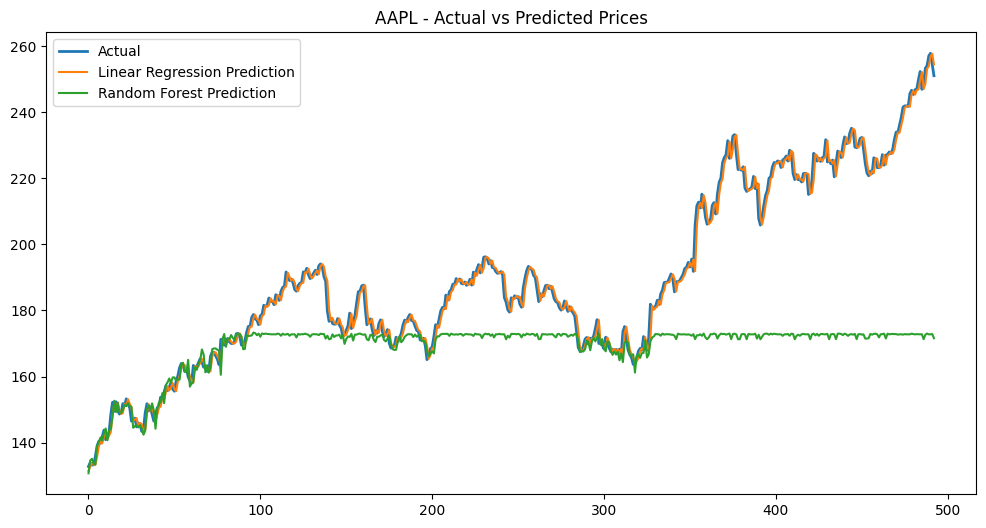

In [11]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(lr_pred, label="Linear Regression Prediction")
plt.plot(rf_pred, label="Random Forest Prediction")
plt.title(f"{stock} - Actual vs Predicted Prices")
plt.legend()
plt.show()


In [20]:
future_preds = []

# Extract last known values as floats, using the correct MultiIndex access for 'Close'
last_close = df[('Close', stock)].iloc[-1].item()
last_ma10   = df['MA10'].iloc[-1].item()
last_ma50   = df['MA50'].iloc[-1].item()
last_return = df['Return'].iloc[-1].item()

for _ in range(7):

    # Ensure scalar floats for input
    last_close_f  = float(last_close)
    last_ma10_f   = float(last_ma10)
    last_ma50_f   = float(last_ma50)
    last_return_f = float(last_return)

    # Create clean 1x4 feature vector
    last_row = np.array([[last_close_f, last_ma10_f, last_ma50_f, last_return_f]], dtype=float)

    # Predict next price
    next_close = float(rf.predict(last_row)[0])
    future_preds.append(next_close)

    # Update temp close series, ensuring it's a Series by using correct MultiIndex access
    temp_close_series = pd.concat([df[('Close', stock)], pd.Series([next_close])], ignore_index=True)

    # Recompute technical indicators — extract scalars safely
    # .rolling().mean().iloc[-1] should return a scalar (or np.nan) when temp_close_series is a Series.
    ma10_val = temp_close_series.rolling(10).mean().iloc[-1]
    ma50_val = temp_close_series.rolling(50).mean().iloc[-1]

    # Use .item() to get the scalar value, which handles np.nan correctly from a scalar Series.
    last_ma10 = ma10_val.item()
    last_ma50 = ma50_val.item()

    # Update return
    last_return = float((next_close - last_close) / last_close)

    # Move close forward
    last_close = next_close

future_preds

[171.59661964416503,
 169.23257293701172,
 167.54338729858398,
 167.22266609191894,
 166.97576637268065,
 167.41861854553224,
 167.00223403930664]

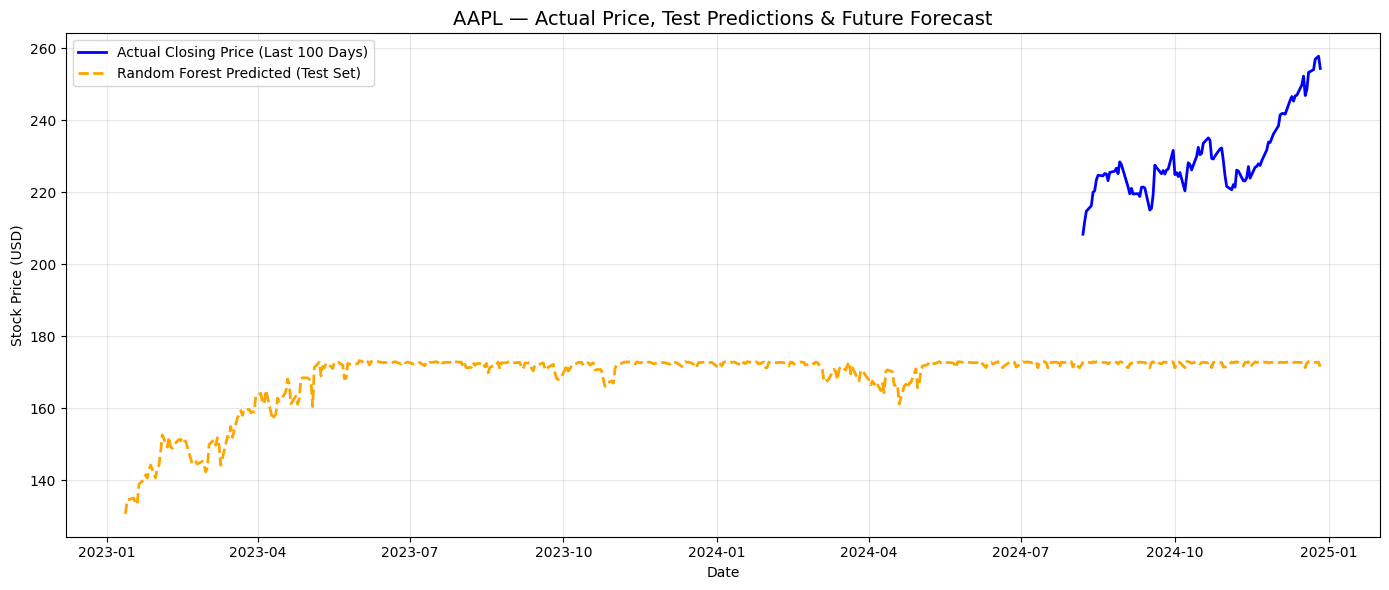

In [21]:
# ---------------- FINAL VISUAL OUTPUT ---------------- #

plt.figure(figsize=(14,6))

# Plot actual last 100 days
plt.plot(df.index[-100:], df["Close"].iloc[-100:],
         label="Actual Closing Price (Last 100 Days)",
         linewidth=2, color="blue")

# Plot test predictions (aligned with test index)
test_index = df.index[-len(y_test):]
plt.plot(test_index, rf_pred,
         label="Random Forest Predicted (Test Set)",
         linewidth=2, linestyle="--", color="orange")

# Plot 7-day future forecast
if "forecast_df" in globals():
    plt.plot(forecast_df.index, forecast_df["pred_close"],
             label="7-Day Future Forecast",
             marker="o", linestyle="--", color="red")

plt.title(f"{stock} — Actual Price, Test Predictions & Future Forecast", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
